In [56]:
import json
import sqlite3
import numpy as np
from typing import List

from gameSimulation.jsonDeEncoders import decodingHooks
from helpers import colorboxplot,makeHistogram

from itertools import groupby

from datetime import datetime

from scipy import stats

# %config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.axes as axes
import matplotlib.pyplot as plt
import matplotlib.ticker as mplTicker
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

mplstyle.use("fast")
mplstyle.use("default")
# mpl.rcParams['figure.figsize'] = [20, 10]

colors = ["green", "blue", "red", "orange", "purple", "gold","lime","magenta","crimson","cyan"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)


db_file_name = "D:/Uni/BA/data/gameHistories_baseline.db"


In [57]:
delta0 = datetime.now()
with sqlite3.connect(db_file_name) as con:
    con.row_factory = lambda _, row: list(row)
    rows_raw = con.execute(
        """select gameSettingsID,roundcount,stepcount,winners from game"""
    ).fetchall()
delta1 = datetime.now()
print("db load finished after {}".format(delta1 - delta0))
rows_raw.sort(key=lambda r: r[0])
delta2 = datetime.now()
print("sort finished after {}".format(delta2 - delta1))

rows = [list(g) for _, g in groupby(rows_raw, lambda r: r[0])]
delta3 = datetime.now()
print("groupby finished after {}".format(delta3 - delta2))
rows.sort(key=lambda rows_sub: np.median([r for _, r, _, _ in rows_sub]))
delta3_1 = datetime.now()
print("sort finished after {}".format(delta3_1 - delta1))

settings = []
roundCounts = []
stepCounts = []
winners = []
for sub_row in rows:
    settings_group = []
    roundCounts_sub = []
    stepCounts_sub = []
    winners_sub = []
    for s, rc,sc,w in sub_row:
        settings_group.append(s)
        roundCounts_sub.append(rc)
        stepCounts_sub.append(sc)
        winners_sub.append(json.loads(w))
    settings.append(min(settings_group) if min( settings_group) == max(settings_group) else -1)
    roundCounts.append(roundCounts_sub)
    stepCounts.append(stepCounts_sub)
    winners.append(winners_sub)
# settings_all = [[s for s, _, _, _ in rows_sub] for rows_sub in rows]
# settings = [min(sub) if min(sub) == max(sub) else -1 for sub in settings_all]
# roundCounts = [[r for _, r, _, _ in rows_sub] for rows_sub in rows]
# stepCounts = [[s for _, _, s, _ in rows_sub] for rows_sub in rows]
# winners = [[json.loads(w) for _, _, _, w in rows_sub] for rows_sub in rows]
delta4 = datetime.now()
print("split finished after {}".format(delta4 - delta3_1))


# stepCounts = [con.execute(
#     '''select stepcount from game where gameSettingsID == (?)''',
#     i).fetchall() for i in distinctSettings]
# winners = [[json.loads(r) for r in con.execute(
#     '''select winners from game where gameSettingsID == (?)''',
#     i).fetchall()] for i in distinctSettings]


len(winners)
settings


db load finished after 0:01:12.366348
sort finished after 0:00:01.882425
groupby finished after 0:00:03.635821
sort finished after 0:00:09.441131
split finished after 0:01:19.718990


[0, 1, 2, 3, 4, 5, 6]

In [58]:
len(rows)
tmp = [np.median([r for _, r, _, _ in rows_sub]) for rows_sub in rows]
tmp[0]


8.0

In [59]:
with sqlite3.connect(db_file_name) as con:
    con.row_factory = lambda _, row: list(row)
    settings_labels = [
        (
            r[0],
            " vs ".join([p.getStrategy().getName()+" [{}]".format(p.getStoneCount())
                        for p in json.loads(r[1], object_hook=decodingHooks)])
        )
        for r in con.execute(
            """select gameSettingsID,players from gameSettings""",
        ).fetchall()
    ]

settings_labels = [(name) for _, name in settings_labels]
print(settings_labels)
print(settings)
labels = [settings_labels[i] for i in settings]
labels


['random [1]', 'random [2]', 'random [3]', 'random [4]', 'random [5]', 'random [6]', 'random [7]']
[0, 1, 2, 3, 4, 5, 6]


['random [1]',
 'random [2]',
 'random [3]',
 'random [4]',
 'random [5]',
 'random [6]',
 'random [7]']

In [60]:
# roundCounts = roundCounts[:4]
# stepCounts = stepCounts[:4]
# labels = labels[:4]
[sum(rc) / len(rc) if len(rc) else -1 for rc in roundCounts]


[8.390554095238095,
 15.43067238095238,
 22.141519142857142,
 28.69065638095238,
 35.15908380952381,
 41.58057028571429,
 47.96424866666667]

In [73]:
[(len(dt), len(dt)*(i+1), labels[i]) for i, dt in enumerate(roundCounts)]


[(10500000, 10500000, 'random [1]'),
 (5250000, 10500000, 'random [2]'),
 (3500000, 10500000, 'random [3]'),
 (2625000, 10500000, 'random [4]'),
 (2100000, 10500000, 'random [5]'),
 (1750000, 10500000, 'random [6]'),
 (1500000, 10500000, 'random [7]')]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


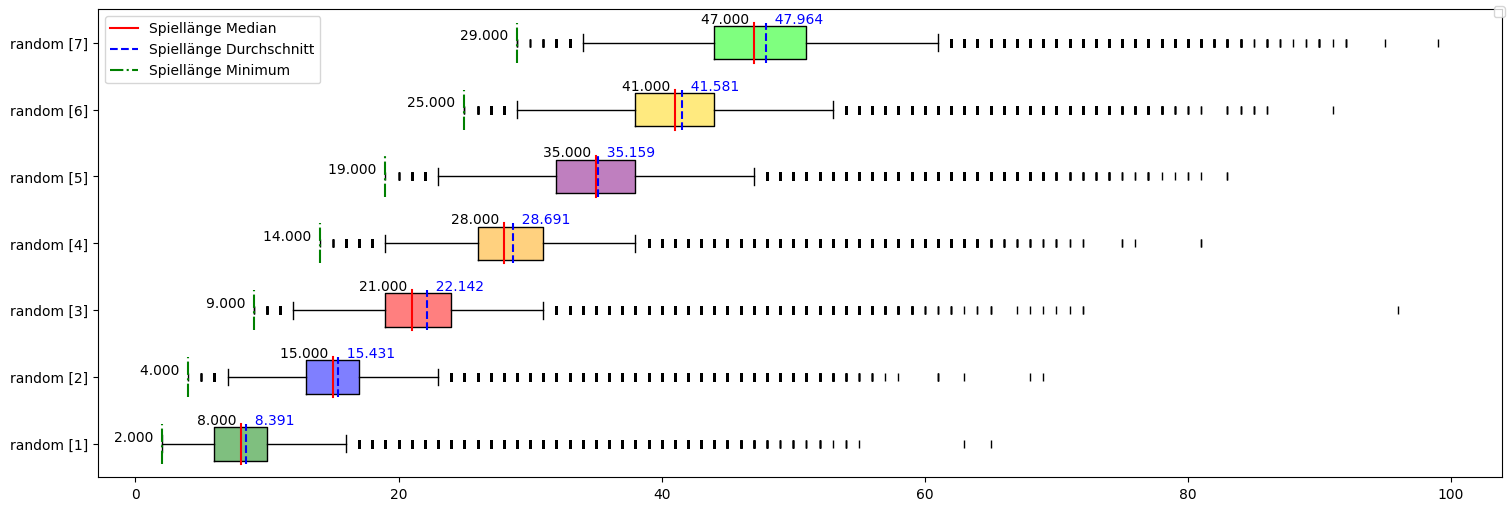

In [62]:
fig, ax = plt.subplot_mosaic([["Boxplots Runden"]], figsize=[
                             15, 5], layout="constrained")
colorboxplot(roundCounts, ax["Boxplots Runden"], labels, colors)
# ax["Boxplots Runden"].set_ylim(.5, len(roundCounts)+.5)
fig.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


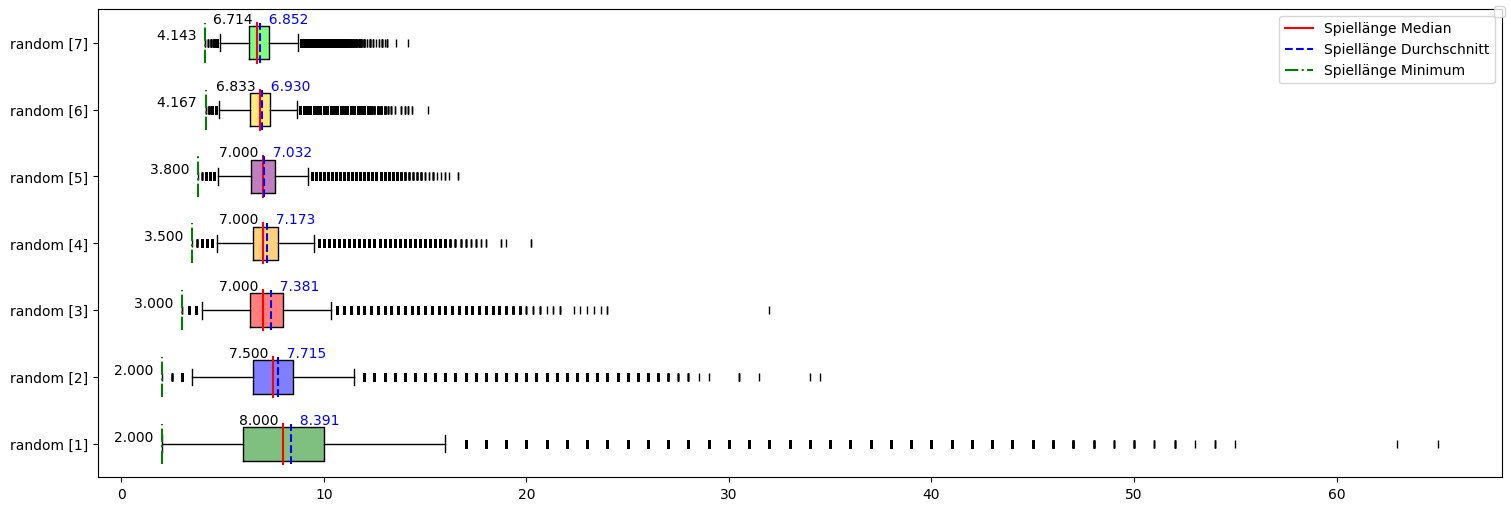

In [63]:
fig, ax = plt.subplot_mosaic([["Boxplots Runden"]], figsize=[15, 5],layout="constrained")
colorboxplot([[rc/(i+1) for rc in part]
             for i, part in enumerate(roundCounts)], ax["Boxplots Runden"], labels, colors)
fig.legend()



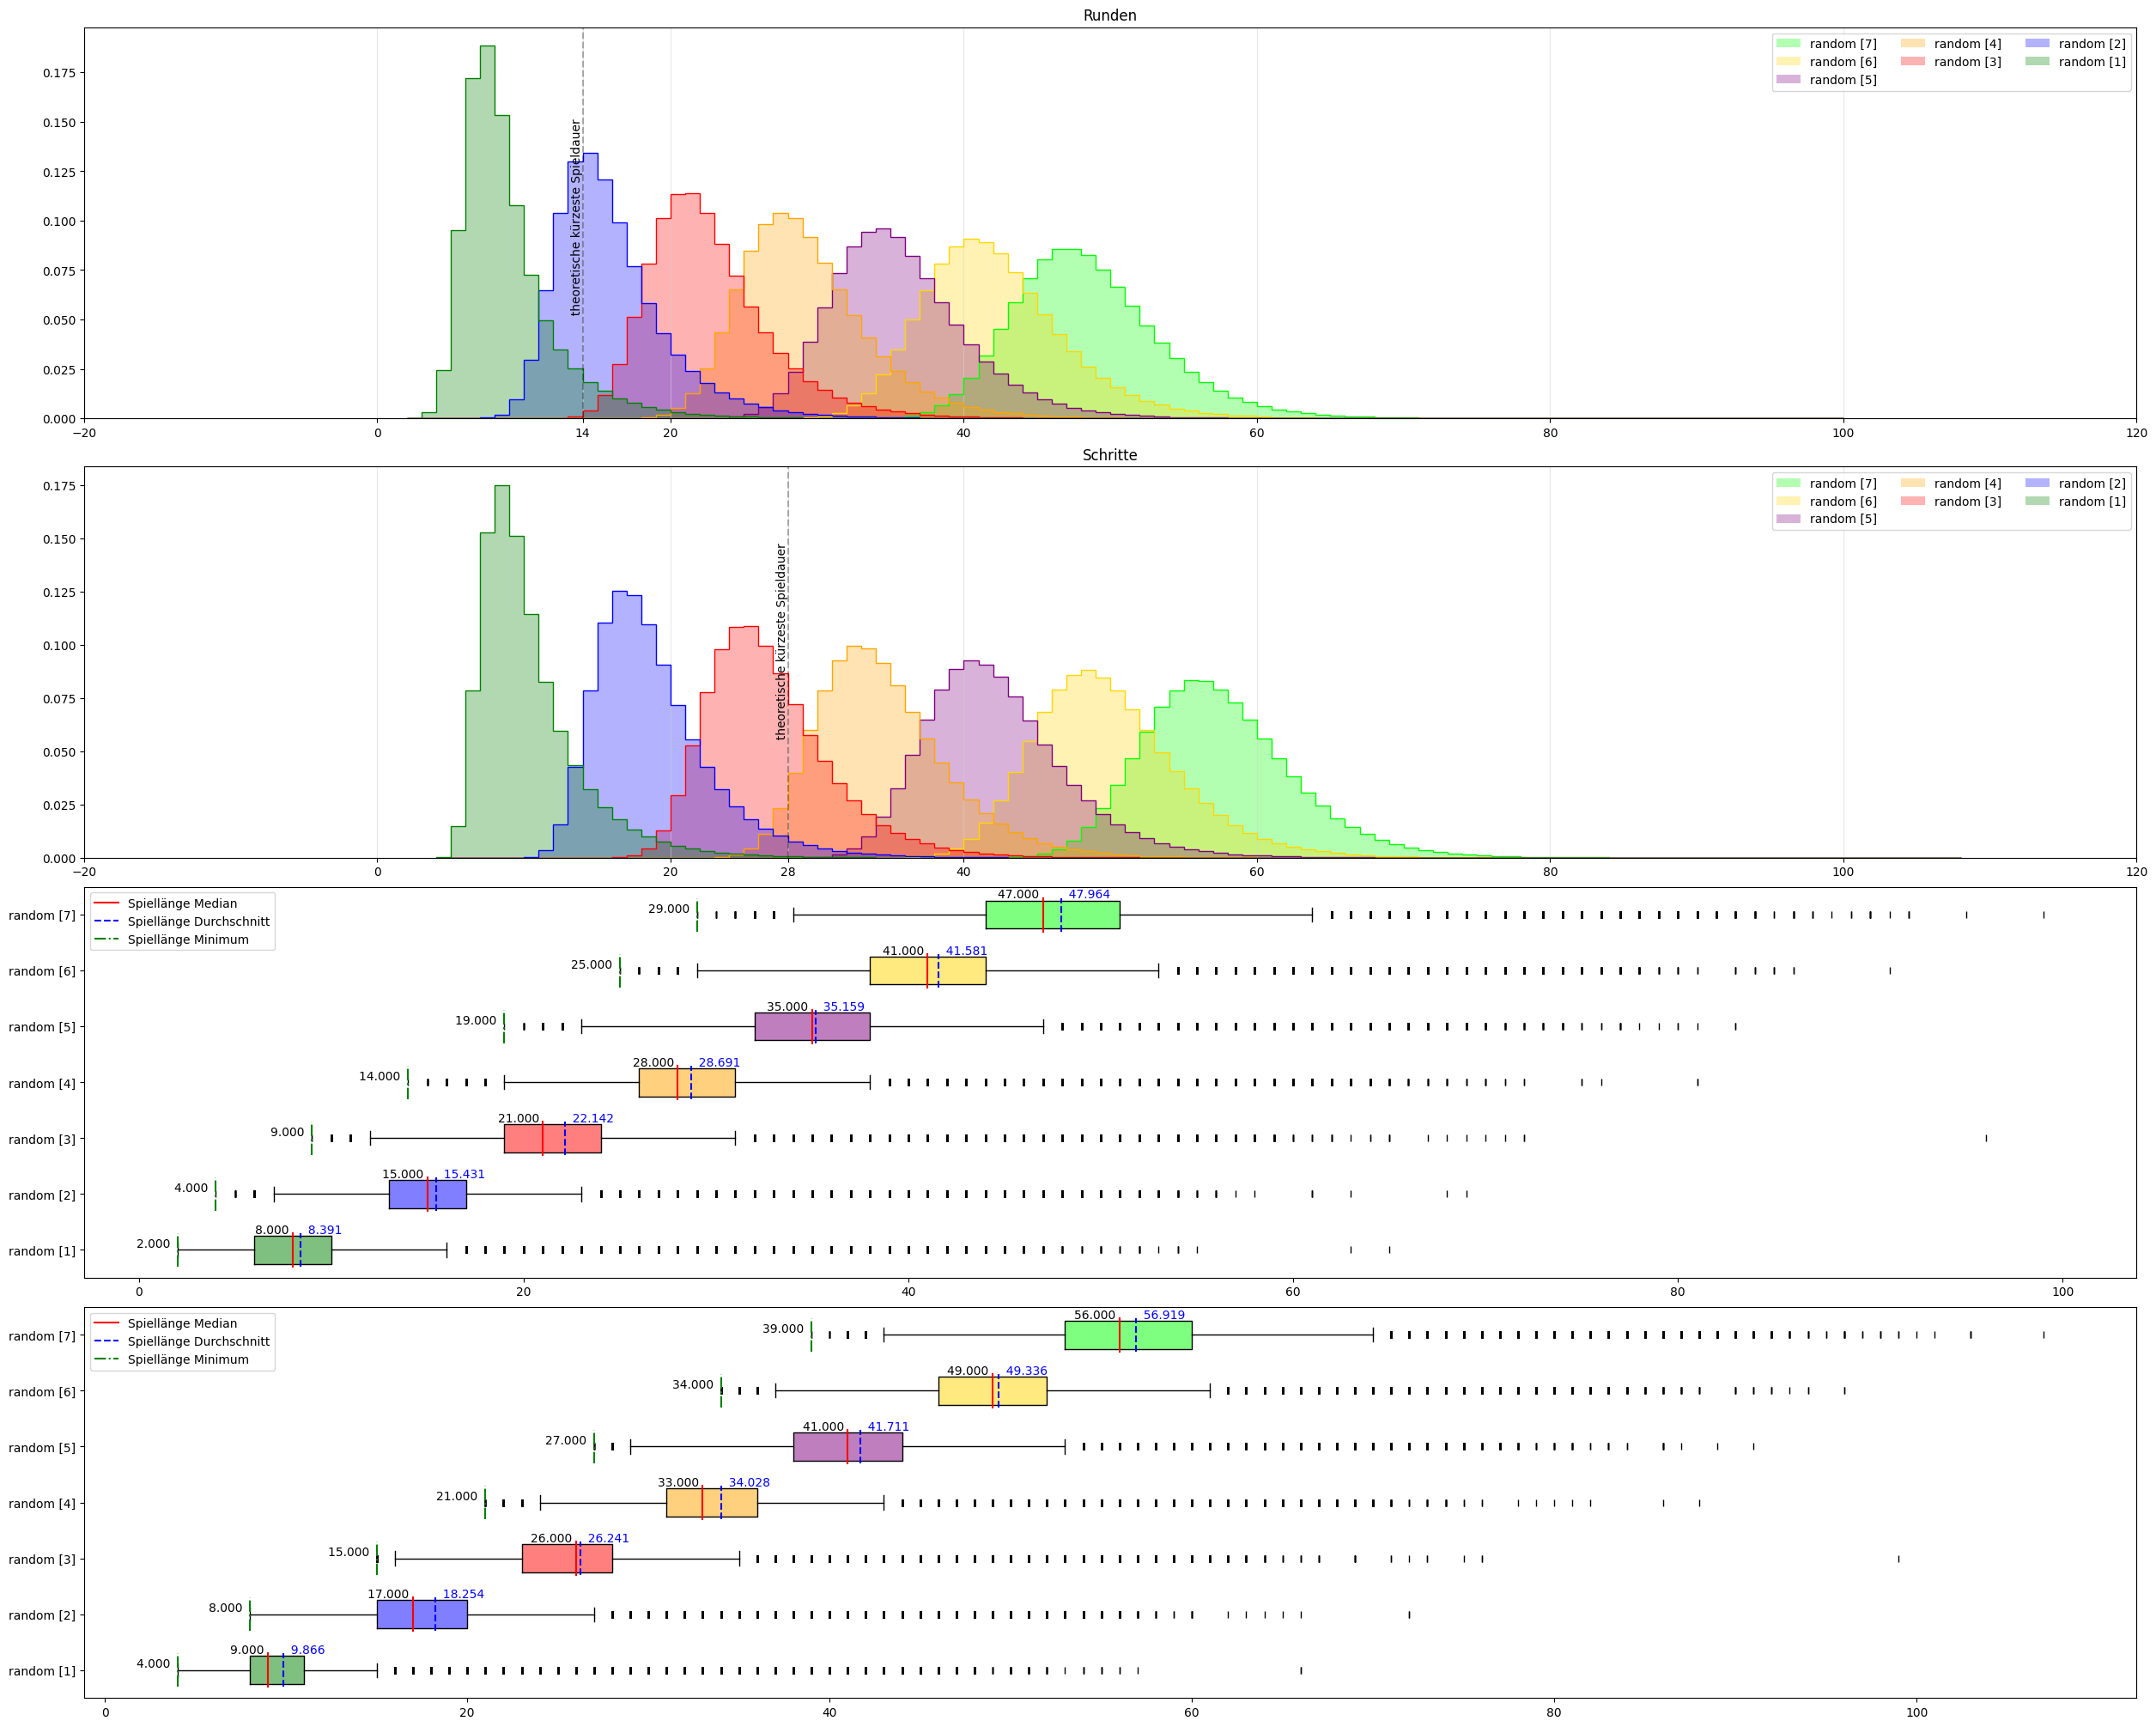

In [64]:
def makeGraph(roundCounts, stepCounts, labels):

    fig, ax = plt.subplot_mosaic(
        [["Runden"], ["Schritte"], ["Boxplots Runden"], ["Boxplots Schritte"]],
        figsize=[25, 20],
        layout="constrained",
    )

    # for i,gl_stacked_ in enumerate(gl_stacked):
    #         ax.bar([x for x, _ in gl_stacked_], [
    #                 y for _, y in gl_stacked_], alpha=0.5, label=xlabels[i])
    #         # ax.plot(gl[i], alpha=0.5)
    ax["Runden"].set_title("Runden")
    makeHistogram(ax["Runden"], roundCounts, labels, colors,14)

    ax["Schritte"].set_title("Schritte")
    makeHistogram(ax["Schritte"], stepCounts, labels, colors, 28)

    colorboxplot(roundCounts, ax["Boxplots Runden"], labels, colors)
    colorboxplot(stepCounts, ax["Boxplots Schritte"], labels, colors)

# makeGraph(roundCounts[a0:a1],stepCounts[a0:a1], labels[a0:a1])
makeGraph(roundCounts, stepCounts, labels)


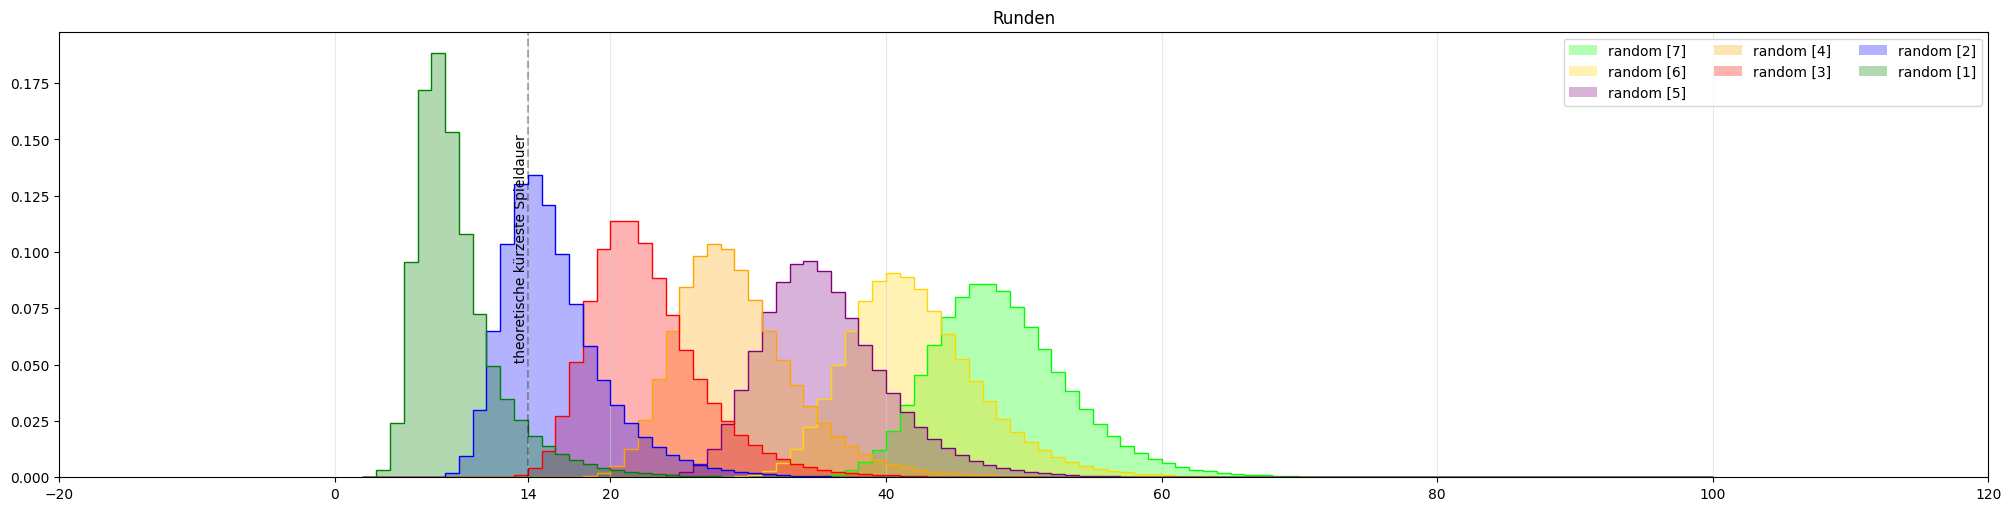

In [65]:
fig, ax = plt.subplot_mosaic( [["Runden"]], figsize=[20, 5], layout="constrained" )

ax["Runden"].set_title("Runden")
makeHistogram(ax["Runden"], roundCounts, labels, colors,14)


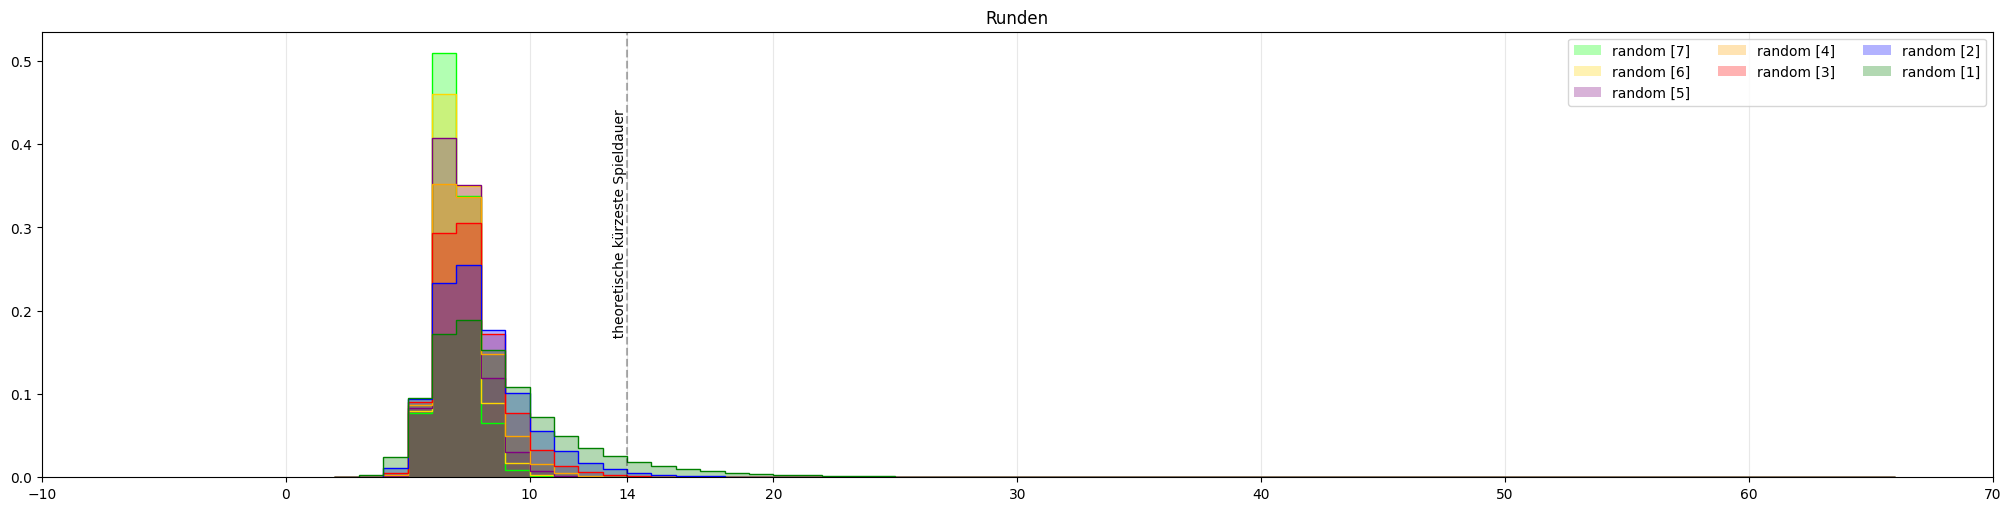

In [74]:
fig, ax = plt.subplot_mosaic([["Runden"]], figsize=[
                             20, 5], layout="constrained")

ax["Runden"].set_title("Runden")
makeHistogram(ax["Runden"], [[rc/(i+1) for rc in part]
                             for i, part in enumerate(roundCounts)], labels, colors, 14, fill=False)


In [67]:
# con = sqlite3.connect("G:/Uni/BA/data/gameHistoriesDice.db")
# con.row_factory = lambda _, row: list(row)
# rows_raw = con.execute( '''select diceroll from game''' ).fetchall()
# # rows_raw.sort(key=lambda r: r[1])
# # rows =  [list(g) for _, g in groupby(rows_raw, lambda r: r[3])]
# dicethrows_raw = [[item for sublist in [json.loads(dr[0]) for dr in rows ]for item in sublist]]

# con.close()


In [68]:
# dicethrows = dicethrows_raw
# [[dt.count(x) for x in range(0,5)]  for dt in dicethrows]
# (sum([len(dt) for dt in winners]),sum([len(dt) for dt in dicethrows]))


In [69]:
# fig, ax = plt.subplot_mosaic([labels], figsize=[15, 10])
# for i, label in enumerate(labels):
#     ax[label].set_title(label)
#     bins = range(0, max(dicethrows[i])+2)
#     ax[label].hist(dicethrows[i], color=colors[i],
#                    density=True,  histtype="step", align="left", bins=bins)
#     ax[label].hist(dicethrows[i], color=colors[i], label=labels,
#                    density=True, histtype="stepfilled", align="left", alpha=.3, bins=bins)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


C:\Users\walli\AppData\Local\Temp/ipykernel_2352/3825855231.py:57: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


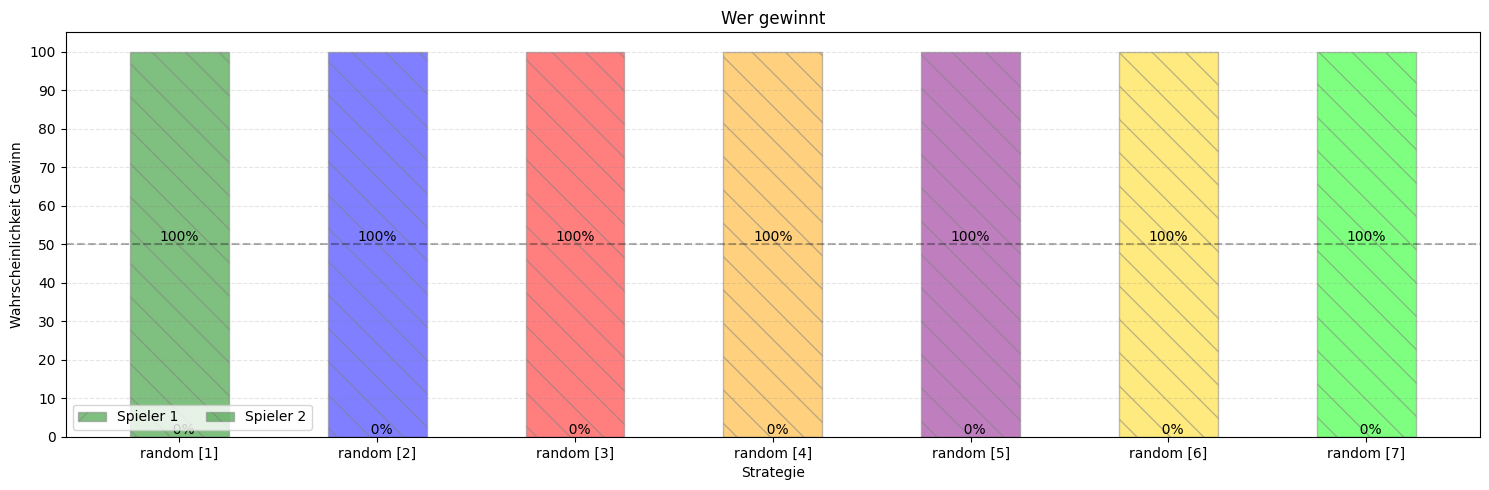

In [70]:
# xlabels = ['No Influence', 'fight', 'fight incl. double']
# xlabels = ["MultiD2Dice(4)",
# "MultiD2Dice(3)",
# "MultiD2DiceNo0(3)",
# "D4()"]
# xlabels=["MF vs MF","S vs MF","S vs S"]
# player0 = [s.count(["p0"]) for s in winners]
# player1 = [s.count(["p1"]) for s in winners]
player0 = [s.count(["p0"]) / len(s) * 100 for s in winners]
player1 = [s.count(["p1"]) / len(s) * 100 for s in winners]
no_one = [s.count([]) / len(s) * 100 for s in winners]
both = [s.count(["p0", "p1"]) / len(s) * 100 for s in winners]
print(player0)
print(player1)

fig, ax = plt.subplots(figsize=[15, 5], layout="constrained")
# hat_graph(ax, xlabels, [player0, player1], ['Player 0', 'Player 1'])

p0 = ax.bar(
    labels,
    player0,
    label="Spieler 1",
    alpha=0.5,
    width=0.5,
    color=colors[0],
    hatch="/",
    edgecolor="gray",
)
p1 = ax.bar(
    labels,
    player1,
    label="Spieler 2",
    alpha=0.5,
    width=0.5,
    bottom=player0,
    color=colors,
    hatch="\\",
    edgecolor="gray",
)
# ab = ax.bar(labels,no_one,label="Abbruch", alpha=.8,width=.5,bottom=[sum(x) for x in zip(player0, player1)])
# ev = ax.bar(labels, both, label="Unentschieden", alpha=.8, width=.5,bottom=[sum(x) for x in zip(player0, player1,no_one)])

ax.bar_label(p0, label_type="center", fmt="%3.5g%%", padding=5)
ax.bar_label(p1, label_type="center", fmt="%3.5g%%", padding=5)
# ax.bar_label(ab, label_type='center',fmt="%3.5g%%", padding=5)
# ax.bar_label(ev, label_type='center',fmt="%3.5g%%", padding=5)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Strategie")
ax.set_ylabel("Wahrscheinlichkeit Gewinn")
ax.set_title("Wer gewinnt")
# ax.legend( loc='lower center', ncol=2)
ax.legend(loc="lower left", ncol=2)
ax.axhline(50, color=(0, 0, 0, 0.3), ls="--")

fig.tight_layout()
ax.set_yticks(np.linspace(0, 100, 11))
ax.grid(axis="y", color=("gray"), alpha=0.2, ls="--")
plt.show()


In [71]:
[x*25000 for i,x in enumerate([ 420//1, 420//2, 420//3, 420//4, 420//5, 420//6, 420//7 ])]



[10500000, 5250000, 3500000, 2625000, 2100000, 1750000, 1500000]